# Loading and images augmentation

### Structure of img annotation:
```python
img = {
    'filename': string
    'width': int,
    'height': int,
    'object': [
        {
            'name': string,  # label name
            'xmin': int,
            'ymin': int,
            'xmax': int,
            'ymax': int
        }, ...
    ]
}
```

In [1]:
import os
import cv2
import csv
import sys
import json
import numpy as np
import pandas as pd

from PIL import Image
from tqdm import tqdm, tqdm_notebook

%matplotlib inline

sys.path.insert(0, '/home/oem/PycharmProjects/tensorflow_yolo/basic-yolo-keras')

In [2]:
from preprocessing import *

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
lcrowdw_settings = {
    'datasets_path': '/media/oem/022cfb2b-3c52-4dfe-a5fb-c5fe826db5e3/Downloads/lcrowdw',
    'scene_type': [
        # 'shibuya_var/bright', 'shibuya_var/dim',
          'shop_var/bright', 'shop_var/dim',
        # 'subway_var/bright', 'subway_var/dim'
    ],
    'people_dense_type': [
        'p_hd_hpc_hp',
        # 'p_ld_lpc_hp',
        # 'p_md_mpc_hp'
    ],
    'images_subdir': 'png',
    'bb_subdir': 'bb'
}

class Rectangle:
    def __init__(self, x_min, x_max, y_min, y_max):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        
        self.x_lenght = np.abs(x_min - x_max)
        self.y_lenght = np.abs(y_min - y_max)
        
        self.area = self.x_lenght * self.y_lenght
        
    def __lt__(self, rectangle):
        return self.area < rectangle.area
    
    def __eq__(self, rectangle):
        return self.x_min == rectangle.x_min \
            and self.x_max == rectangle.x_max \
            and self.y_min == rectangle.y_min \
            and self.y_max == rectangle.y_max
        
    def has_intersection(self, rectangle):
        hoverlaps = not((self.x_min > rectangle.x_max) or (self.x_max < rectangle.x_min))
        voverlaps = not((self.y_max < rectangle.y_min) or (self.y_min > rectangle.y_max))
        return hoverlaps and voverlaps
        
    def intersection_percent(self, rectangle):
        if not self.has_intersection(rectangle):
            return 0.0
        
        intersection_width = np.abs(min(self.x_max, rectangle.x_max) - max(self.x_min, rectangle.x_min))
        intersection_height = np.abs(min(self.y_max, rectangle.y_max) - max(self.y_min, rectangle.y_min))
        intersection_area = intersection_width * intersection_height
        return (intersection_area / self.area) * 100

In [4]:
def _parse_annotation_lcrowdw(bb_dir, images_dir):
    imgs = []

    def get_sorted_filenamelist(path, ext):
        return sorted(
            map(lambda filename: os.path.join(path, filename),
                filter(lambda filename: filename.endswith(ext),
                       os.listdir(path))))

    for image_path, ann_path in zip(get_sorted_filenamelist(images_dir, 'png'),
                                    get_sorted_filenamelist(bb_dir, 'csv')):
        img = {}
        img['filename'] = image_path
        img['width'], img['height'] = Image.open(image_path).size
        
        with open(ann_path) as csv_annot:
            reader = csv.reader(csv_annot, delimiter=',')
            annotations = [
                Rectangle(x_min=round(float(row[1])),
                          x_max=round(float(row[3])),
                          y_min=round(float(row[2])),
                          y_max=round(float(row[4])))
                for row in reader
            ]
            annotations = list(filter(lambda ann: not np.any([ann.intersection_percent(ann_) >= 60.0 
                                                          for ann_ in filter(lambda x: x != ann, annotations)]), 
                                      annotations))
            img['object'] = [
                {
                    'name': 'person',
                    'xmin': ann.x_min,
                    'ymin': ann.y_min,
                    'xmax': ann.x_max,
                    'ymax': ann.y_max
                }
                for ann in sorted(annotations)[-20:]
            ]
        imgs.append(img)

    return imgs


def _load_all_lcrowdw_annotations(lcrowdw_settings):
    all_imgs = []

    for scene_type in lcrowdw_settings['scene_type']:
        for people_dense_type in lcrowdw_settings['people_dense_type']:
            imgs = _parse_annotation_lcrowdw(
                os.path.join(lcrowdw_settings['datasets_path'], scene_type, people_dense_type,
                             lcrowdw_settings['bb_subdir']),
                os.path.join(lcrowdw_settings['datasets_path'],
                             scene_type, people_dense_type,
                             lcrowdw_settings['images_subdir'])
            )
            all_imgs += imgs

    return all_imgs

In [5]:
data = _load_all_lcrowdw_annotations(lcrowdw_settings)

In [6]:
import xml.etree.ElementTree as ET
from xml.dom import minidom


def prettify(elem):
    rough_string = ET.tostring(elem, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent='\t')


for img in tqdm_notebook(data):
    main = ET.Element('annotation', attrib={'verified': 'no'})
    ET.SubElement(main, 'folder').text = 'png'
    ET.SubElement(main, 'filename').text = os.path.split(img['filename'])[1]
    ET.SubElement(main, 'path').text = img['filename']
    ET.SubElement(main, 'segmented').text = '0'

    source = ET.SubElement(main, 'segmented')
    ET.SubElement(source, 'database').text = 'Unknown'

    size = ET.SubElement(main, 'size')
    ET.SubElement(size, 'width').text = str(img['width'])
    ET.SubElement(size, 'height').text = str(img['height'])
    ET.SubElement(size, 'depth').text = '3'

    for img_obj in img['object']:
        obj = ET.SubElement(main, 'object')
        ET.SubElement(obj, 'name').text = 'person'
        ET.SubElement(obj, 'pose').text = 'Unspecified'
        ET.SubElement(obj, 'truncated').text = '0'
        ET.SubElement(obj, 'difficult').text = '0'

        bbox = ET.SubElement(obj, 'bndbox')
        ET.SubElement(bbox, 'xmin').text = str(img_obj['xmin'])
        ET.SubElement(bbox, 'ymin').text = str(img_obj['ymin'])
        ET.SubElement(bbox, 'xmax').text = str(img_obj['xmax'])
        ET.SubElement(bbox, 'ymax').text = str(img_obj['ymax'])

    path, filename = os.path.split(img['filename'])
    with open(os.path.join(path, filename[:-4] + '.xml'), 'w') as f:
        f.write(prettify(main))
    

HBox(children=(IntProgress(value=0, max=9826), HTML(value='')))

In [7]:
ann_path = '/media/oem/022cfb2b-3c52-4dfe-a5fb-c5fe826db5e3/Downloads/lcrowdw/shop_var/bright/p_hd_hpc_hp/png/'

imgs = []
for item in tqdm_notebook(os.listdir(ann_path)):
    if not item.endswith('xml'):
        continue
    tree = ET.parse(os.path.join(ann_path, item))
    
    if 'verified' in tree.getroot().attrib and tree.getroot().attrib['verified'] != 'yes':
        continue
        
    img = {}
    img['filename'] = tree.find('path').text
    img['width'], img['height'] = int(tree.find('size').find('width').text), int(tree.find('size').find('height').text)

    img['object'] = [
                {
                    'name': 'person',
                    'xmin': int(obj.find('bndbox').find('xmin').text),
                    'ymin': int(obj.find('bndbox').find('ymin').text),
                    'xmax': int(obj.find('bndbox').find('xmax').text),
                    'ymax': int(obj.find('bndbox').find('ymax').text)
                }
                for obj in tree.findall('object')
            ]
    imgs.append(img)
    
with open(os.path.join(ann_path, 'annotations.pickle'), 'wb') as f:
    pickle.dump(imgs, f)

HBox(children=(IntProgress(value=0, max=6653), HTML(value='')))

In [8]:
ann_path = '/media/oem/022cfb2b-3c52-4dfe-a5fb-c5fe826db5e3/Downloads/lcrowdw/shop_var/bright/p_hd_hpc_hp/png/'
with open(os.path.join(ann_path, 'annotations.pickle'), 'rb') as f:
    data = pickle.load(f)

In [9]:
generator_config = {
    'IMAGE_H'         : 500, 
    'IMAGE_W'         : 500,
    'GRID_H'          : 20,  
    'GRID_W'          : 20,
    'BOX'             : 5,
    'LABELS'          : ['person'],
    'CLASS'           : 1,
    'ANCHORS'         : [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828],
    'BATCH_SIZE'      : 16,
    'TRUE_BOX_BUFFER' : 50,
}

In [10]:
batches = BatchGenerator(data, generator_config)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


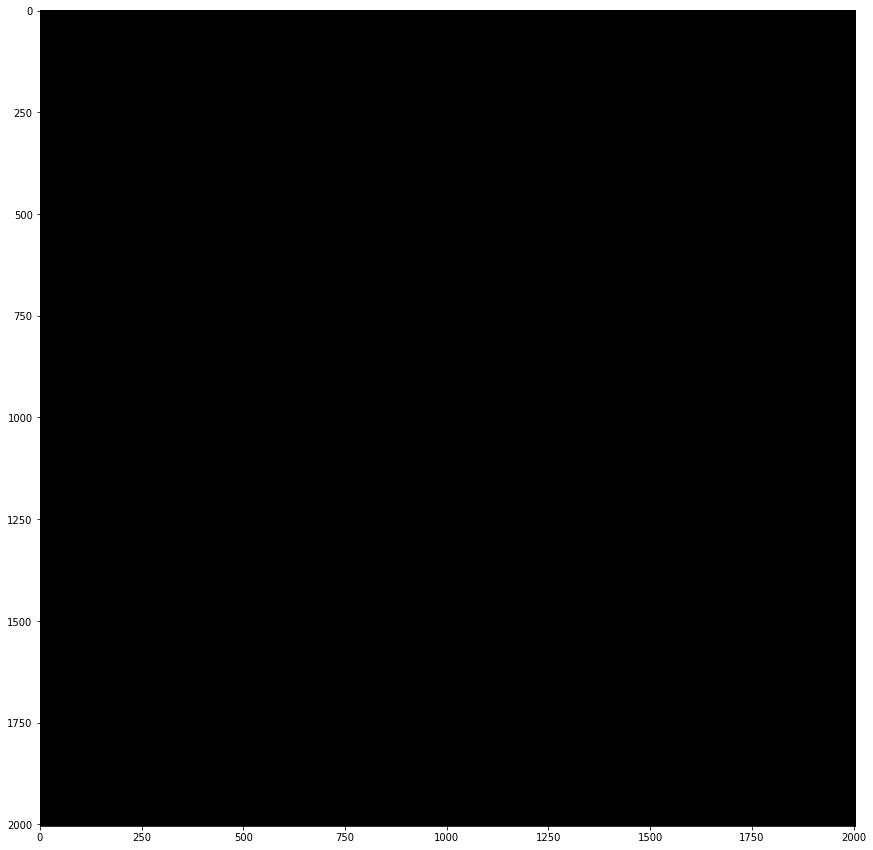

In [12]:
import matplotlib.pyplot as plt
import cv2


def imshow_grid(data, height=None, width=None, normalize=False, padsize=1, padval=0):
    '''
    Take an array of shape (N, H, W) or (N, H, W, C)
    and visualize each (H, W) image in a grid style (height x width).
    '''
    if normalize:
        data -= data.min()
        data /= data.max()

    N = data.shape[0]
    if height is None:
        if width is None:
            height = int(np.ceil(np.sqrt(N)))
        else:
            height = int(np.ceil( N / float(width) ))

    if width is None:
        width = int(np.ceil( N / float(height) ))

    assert height * width >= N

    # append padding
    padding = ((0, (width*height) - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))

    # tile the filters into an image
    data = data.reshape((height, width) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((height * data.shape[1], width * data.shape[3]) + data.shape[4:])

    plt.imshow(data)


plt.rcParams['figure.figsize'] = (15, 15)
imshow_grid(batches[6][0][0], normalize=True)

In [ ]:
import os
import filecmp
import pandas as pd
from tqdm import tqdm_notebook, tnrange
from PIL import Image


OPEN_IMAGES_PATH = '/media/oem/022cfb2b-3c52-4dfe-a5fb-c5fe826db5e3/openimages/'


def get_existing_pictures():
    return set([f.split('.')[0] for f in os.listdir(os.path.join(OPEN_IMAGES_PATH, 'images_dataset')) 
                if f.endswith('.jpg')])


def parse_openimages():
    annotations_box = pd.read_pickle(os.path.join(OPEN_IMAGES_PATH, 'annotations_box.pickle'))
    dict_ = pd.read_pickle(os.path.join(OPEN_IMAGES_PATH, 'dict.pickle'))
    
    existing_pictures = set([f.split('.')[0] 
                             for f in os.listdir(os.path.join(OPEN_IMAGES_PATH, 'images_dataset')) 
                             if f.endswith('.jpg') and f.split('.')[0] in annotations_box.index])
    
    person_label_names = {
        dict_[dict_['label_display_name'] == name].index[0]: name
        for name in ['Person', 'Man', 'Woman', 'Boy', 'Girl']
    }
    
    annotations_box = annotations_box[annotations_box['label_name'].isin(person_label_names.keys())]
    annotations_box = annotations_box[annotations_box.index.isin(existing_pictures)]
    annotations_box = annotations_box.drop(['source', 'confidence', 'is_occluded', 
                                            'is_truncated', 'is_group_of', 'is_depiction', 'is_inside'], 
                                           axis=1)
    
    images = []
    for f in tqdm_notebook(existing_pictures):
        filtered_annotations_box = annotations_box[annotations_box.index == f]
                                                       
        if len(filtered_annotations_box) == 0:
            continue
        
        img = {}
        image_filename = os.path.join(OPEN_IMAGES_PATH, 'images_dataset', f + '.jpg')
        img['filename'] = f + '.jpg'
        img['width'], img['height'] = Image.open(image_filename).size

        img['object'] = [
                {
                    'name': 'person',
                    'xmin': int(annot_row['x_min'] * img['width']),
                    'xmax': int(annot_row['x_max'] * img['width']),
                    'ymin': int(annot_row['y_min'] * img['height']),
                    'ymax': int(annot_row['y_max'] * img['height'])
                }
                for _, annot_row in filtered_annotations_box.iterrows()
            ]
        
        images.append(img)
        
    return images

In [ ]:
data = parse_openimages()

In [ ]:
for img in data:
    img['filename'] = os.path.join(OPEN_IMAGES_PATH, 'images_dataset', img['filename'])

In [ ]:
def get_existing_files():
    return [os.path.join(OPEN_IMAGES_PATH, 'images_dataset', f)
            for f in os.listdir(os.path.join(OPEN_IMAGES_PATH, 'images_dataset')) 
            if f.endswith('.jpg')]

error_images = [os.path.join(OPEN_IMAGES_PATH, 'images_dataset', 'flickr_notfound_small.jpg'), 
                os.path.join(OPEN_IMAGES_PATH, 'images_dataset', 'flickr_notfound_big.jpg')]
existing_pictures = get_existing_files()
bad_images = set()
for image_filename in tqdm_notebook(existing_pictures[:1000]):
    try:
        image_size = os.stat(image_filename).st_size
        assert image_size > 1024  # It must be more than 1Kb
        assert not np.any([filecmp.cmp(i, image_filename) for i in error_images])

        image = Image.open(image_filename)
        image.verify()

        assert image.size[0] < 10000 and image.size[1] < 10000  # Too big image for Flickr (likely it is invalid image)
    except:
        bad_images.add(image_filename)

In [ ]:
import pickle

with open(os.path.join(OPEN_IMAGES_PATH, 'images_annotations.pickle'), 'rb') as f:
    images = pickle.load(f)

In [ ]:
images_filtered = list(filter(lambda x: len(x['object']) > 1, images))

In [ ]:
len(images_filtered)

In [ ]:
queue_dataset_path = '/media/oem/022cfb2b-3c52-4dfe-a5fb-c5fe826db5e3/Downloads/queue_dataset/'

def load_queue_dataset():
    images = []
    
    for folder in os.listdir(queue_dataset_path):
        frames_path = os.path.join(queue_dataset_path, folder, 'data/obj/')
        
        for image_filename in os.listdir(frames_path):
            if not image_filename.endswith('jpg'):
                continue
            image = {}
            image['filename'] = os.path.join(frames_path, image_filename)
            
            
            with open(image['filename'][:-4] + '.txt') as f:
                reader = csv.reader(f, delimiter=' ')
                objects = [list(map(float, row[1:])) for row in reader]
                
            image['object'] = [{
                'name': 'person',
                'xmin': int(o[0] * image['width']) - (int(o[2] * image['width']) // 2),
                'ymin': int(o[1] * image['height']) - (int(o[3] * image['height']) // 2),
                'xmax': int(o[0] * image['width']) + (int(o[2] * image['width']) // 2),
                'ymax': int(o[1] * image['height']) + (int(o[3] * image['height']) // 2)
            } for o in objects]
            
            images.append(image)
            
    return images

In [ ]:
data = load_queue_dataset()

In [ ]:
from scipy.io import loadmat

prw_dataset_path = '/media/oem/022cfb2b-3c52-4dfe-a5fb-c5fe826db5e3/Downloads/PRW-v16.04.20/'


def load_prw_dataset():
    images = []
    
    for image_filename in tqdm_notebook(os.listdir(os.path.join(prw_dataset_path, 'frames'))):
        if not image_filename.endswith('jpg'):
            continue
            
        image = {}
        image['filename'] = os.path.join(prw_dataset_path, 'frames', image_filename)
        image['width'], image['height'] = Image.open(image['filename']).size
        
        with open(os.path.join(prw_dataset_path, 'annotations', image_filename + '.mat'), 'rb') as f:
            objects = loadmat(f)
            if 'box_new' not in objects:
                continue
                
        objects = objects['box_new'][:,1:].astype(np.int)
        image['object'] = [{
                    'name': 'person',
                    'xmin': o[0],
                    'ymin': o[1],
                    'xmax': o[0] + o[2],
                    'ymax': o[1] + o[3] 
                } for o in objects]
        images.append(image)
        
    return images

In [ ]:
data = load_prw_dataset()

In [ ]:
queue_path = '/media/oem/022cfb2b-3c52-4dfe-a5fb-c5fe826db5e3/samples/peoples/queue_dataset/'